# Part I

In [221]:
a)	Daily sign-ups is an important metric to quantify the success of growth strategies and campaigns led by our country managers. 
Write a query to calculate the mean, the standard deviation and the median of weekly sign-ups per country.

select
	U.country, 
	avg(U.signups),
	stddev(U.signups) as standarddeviation, 
	percentile_disc(0.5) within group (order by U.signups) as median_of_signups
from
(
	select country,count(*) as signups,extract(week from created_date)+1 as dayofweek 
	from users 
	group by country,extract(week from created_date)+1
) AS U
group by U.country;

b)	We care about growth and also if users are engaged with our product. One of the many ways to track if they are “active” is from their card payment transactions. 
Write a query to calculate the volume of monthly card payment in USD per age group in the interval of 10?

select ntile as age_bin,
	min(y.age) as minimum_age,
	max(y.age) as maximum_age,
	sum(y.monthly_usd_card_payments_count) as total_monthly_usd_card_payments_count_by_age_bin
from
( 
	select x.user_age as age,
		x.monthly_usd_card_payments_count as monthly_usd_card_payments_count,
		ntile(10) over(order by x.user_age)
	from
	(
		select trans.user_id,
			trans.monthly_usd_card_payments_count as monthly_usd_card_payments_count,
			trans.month_of,
			customer.birth_year,
			customer.user_age as user_age
		from
		(
			select user_id,
				count(*) as monthly_usd_card_payments_count,
				extract(month from created_date) as month_of 
			from transactions 
			where transactions_currency='USD' and 
				transactions_type='CARD_PAYMENT'
			group by user_id,extract(month from created_date)
		) as trans
		LEFT JOIN
		(
			select user_id,
			birth_year,
			(extract(ISOYEAR  from current_date)-birth_year)as user_age,
			current_date 
			from users
		) as customer
		on trans.user_id=customer.user_id
	)x
)y
group by ntile
order by ntile;

c)	We are interested in the spending patterns of non standard vs standard users. 
Write a query to show the number of days where the average card payments volume of non standard users is less than standard users.

select count(*) as card_payments_non_standard_Less_than_standard
from(
select st.created_date as created_date, ('{' || string_agg('"' || st.userplan || '": ' || st.counts, ',') || '}')::json as card_payment_vol 
from (
select customer.userplantype as userplan,count(*) as counts,trans.created_date as created_date
from
(
	select user_id,
		plan,
		case when plan='STANDARD' then 'STANDARD'
		else 'NON-STANDARD' end userplantype
	from users
) as customer
LEFT JOIN
(
	select DATE(created_date) as created_date,
		transaction_id,
		user_id 
	from transactions 
	where transactions_type='CARD_PAYMENT'
) as trans
ON customer.user_id=trans.user_id
group by customer.userplantype,trans.created_date
) as st
group by st.created_date
) as stb
where json_extract_path_text(stb.card_payment_vol,'STANDARD')<json_extract_path_text(stb.card_payment_vol,'NON-STANDARD')





SyntaxError: invalid syntax (<ipython-input-221-727b7d3290af>, line 1)

# Part II 

# Importing Packages

In [1]:
import pandas as pd 
import numpy as np
from datetime import timedelta
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Loading Dateset

In [2]:
users=pd.read_csv("data/rev-users.csv")
transactions=pd.read_csv("data/rev-transactions.csv")
devices=pd.read_csv("data/rev-devices.csv")
notifications=pd.read_csv("data/rev-notifications.csv")

## Userdefined Fucntion to explore data

In [74]:
def inspect_data(data):
    return pd.DataFrame({"Data Type":data.dtypes, "No of Levels":data.apply(lambda x: x.nunique(),axis=0),"No of Nulls":data.apply(lambda x: x.isnull().sum(),axis=0) ,"Levels":data.apply(lambda x: str(x.unique()),axis=0)})

## Converting appropriate to date columns from string 

In [150]:
users['created_date']=pd.to_datetime(users['created_date'],format='%Y-%m-%d %H:%M')
transactions['created_date']=pd.to_datetime(transactions['created_date'],format='%Y-%m-%d %H:%M')
notifications['created_date']=pd.to_datetime(notifications['created_date'],format='%Y-%m-%d %H:%M')

In [109]:
max_date=transactions['created_date'].max()

In [5]:
min_date=transactions['created_date'].min()

In [6]:
transactions.isnull().sum()

transaction_id                 0
transactions_type              0
transactions_currency          0
amount_usd                     0
transactions_state             0
ea_cardholderpresence    1170594
ea_merchant_mcc          1158658
ea_merchant_city         1158794
ea_merchant_country      1158979
direction                      0
user_id                        0
created_date                   0
dtype: int64

In [7]:
max_date

datetime.date(2019, 5, 16)

## Extracting Frequency, Recency, Monetary value and Duration of user.  Using them we calculated customer live value (palive) which is the key metrics to define a user is engaged or unengaged user. 
#### Frequency represents the number of repeat transcations the user has made
#### Recency represents the age of the user when they made their most recent purchases
#### Monetary value represents the average value of a given user’s transaction


In [28]:
from lifetimes.utils import summary_data_from_transaction_data

customer_transactions = summary_data_from_transaction_data(transactions,
                                             customer_id_col = 'user_id',
                                             datetime_col = 'created_date',
                                                           monetary_value_col='amount_usd',
                                             observation_period_end=max_date)

In [9]:
customer_transactions.head()

,frequency,recency,T,monetary_value
user_id,,,,
user_0,121.0,471.0,485.0,112.742231
user_1,48.0,391.0,470.0,125.914167
user_10,296.0,492.0,497.0,175.989595
user_100,72.0,477.0,486.0,287.886389
user_1000,15.0,171.0,495.0,1420.922667


In [10]:
customer_transactions.describe()

,frequency,recency,T,monetary_value
count,18766.000000,18766.000000,18766.000000,1.876600e+04
mean,46.244378,214.798412,284.882980,8.745831e+05
std,56.770449,132.543797,108.042056,7.519481e+07
min,0.000000,0.000000,6.000000,0.000000e+00
25%,7.000000,123.000000,193.000000,3.178590e+01
50%,25.000000,210.000000,278.000000,8.292369e+01
75%,64.000000,317.000000,370.000000,1.767824e+02
max,462.000000,494.000000,500.000000,9.929086e+09


### Plotting distrubution of Frequency, Recency and Duration of the users

C:\Users\littu\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
C:\Users\littu\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
C:\Users\littu\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


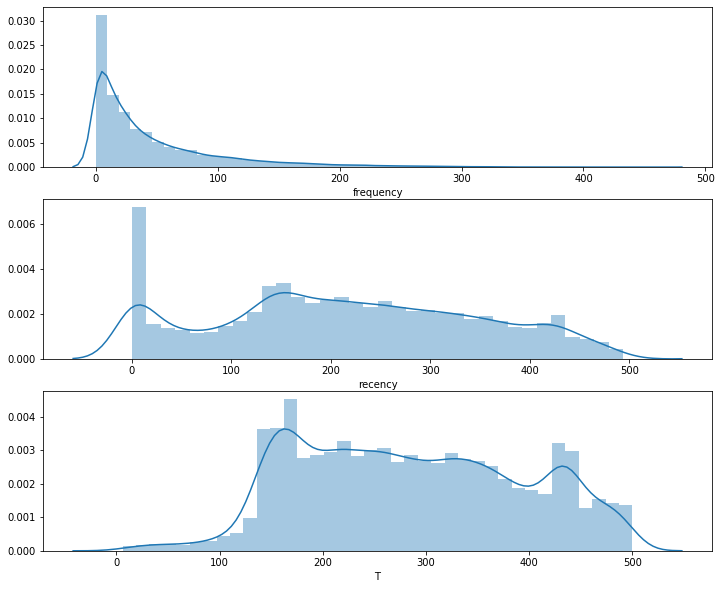

In [11]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of Frequency
plt.subplot(3, 1, 1); 
sns.distplot(customer_transactions['frequency'])
# Plot distribution of Recency
plt.subplot(3, 1, 2); 
sns.distplot(customer_transactions['recency'])
# Plot distribution of Customer duration
plt.subplot(3, 1, 3); 
sns.distplot(customer_transactions['T'])
# Show the plot
plt.show()

In [12]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(customer_transactions['frequency'], customer_transactions['recency'], customer_transactions['T'])

<lifetimes.BetaGeoFitter: fitted with 18766 subjects, a: 0.05, alpha: 3.64, b: 0.52, r: 0.69>

In [20]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.687309,0.006200,0.675157,0.699460
alpha,3.636906,0.046479,3.545806,3.728005
a,0.048562,0.000971,0.046659,0.050466
b,0.519209,0.010257,0.499106,0.539312


C:\Users\littu\Anaconda3\lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:205: RuntimeWarning: overflow encountered in double_scalars
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


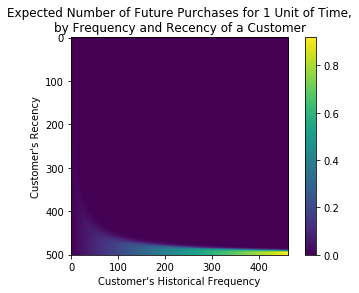

In [14]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf);

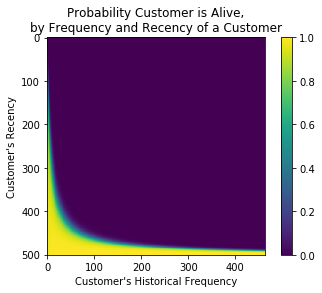

In [15]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf);

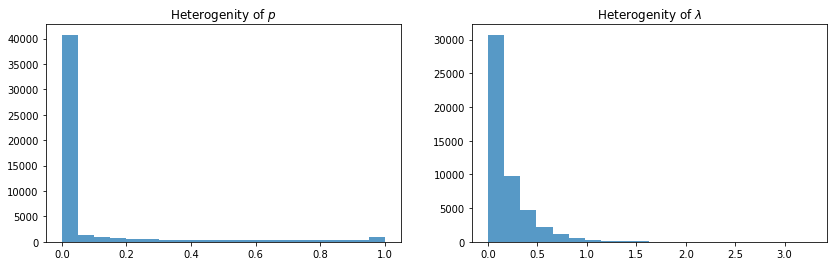

In [21]:
from scipy.stats import gamma, beta

gbd = beta.rvs(bgf.params_['a'], bgf.params_['b'], size = 50000)
ggd = gamma.rvs(bgf.params_['r'], scale=1./bgf.params_['alpha'], size = 50000)
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title('Heterogenity of $p$')
temp = plt.hist(gbd, 20, alpha=0.75)
plt.subplot(122)
plt.title('Heterogenity of $\lambda$')
temp = plt.hist(ggd, 20, alpha=0.75)

While active, the number of transactions made by a customer follows a Poisson process with transaction rate λ
.
Heterogeneity in λ
across customers follows a Gamma distribution with shape parameter r and scale parameter α
.
At time zero and right after each purchase the customer becomes inactive with a constant probability p
.
Heterogeneity in p
across customers follows a Gamma distribution with parameter a and b
.
The transaction rate λ
and the dropout probability p vary independently across customers.

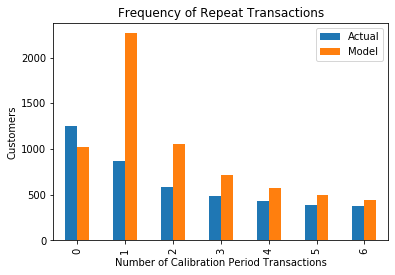

In [23]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf);

from lifetimes.utils import calibration_and_holdout_data

customer_cal_holdout = calibration_and_holdout_data(transactions, 'user_id', 'created_date',freq = 'D',calibration_period_end='2018-01-01', observation_period_end='2019-05-16')

In [ ]:
The red line represents the boundary between the calibration period on the left and the holdout period on the right
model capturing predicting cumulative transactions well

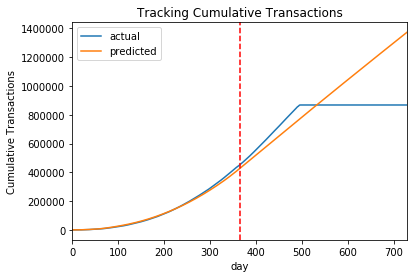

In [23]:
from lifetimes.plotting import plot_cumulative_transactions
plot_cumulative_transactions(bgf, transactions, 'created_date', 'user_id', 730, 365);

In [ ]:
Model captuing general trends in the data

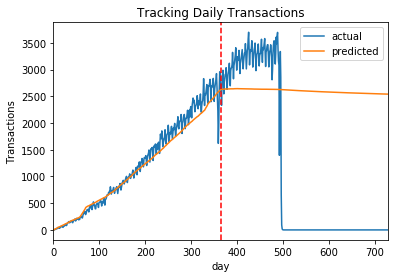

In [24]:
from lifetimes.plotting import plot_incremental_transactions
plot_incremental_transactions(bgf, transactions, 'created_date', 'user_id', 730, 365);

In [44]:
customer_transactions['palive'] = bgf.conditional_probability_alive(customer_transactions['frequency'],customer_transactions['recency'],customer_transactions['T'])


In [45]:
customer_transactions.head()

,frequency,recency,T,monetary_value,palive,churn
user_id,,,,,,
user_0,121.0,471.0,485.0,112.742231,0.986337,not churned
user_1,48.0,391.0,470.0,125.914167,0.119395,churned
user_10,296.0,492.0,497.0,175.989595,0.996782,not churned
user_100,72.0,477.0,486.0,287.886389,0.997392,not churned
user_1000,15.0,171.0,495.0,1420.922667,0.000021,churned


C:\Users\littu\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


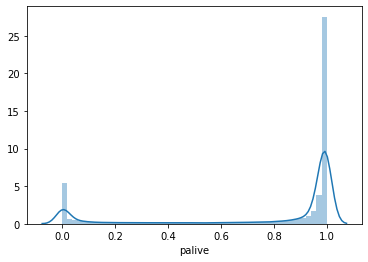

In [30]:
sns.distplot(customer_transactions['palive']);

In [35]:
customer_transactions['churn'] = ['churned' if p < .8 else 'not churned' for p in customer_transactions['palive']]


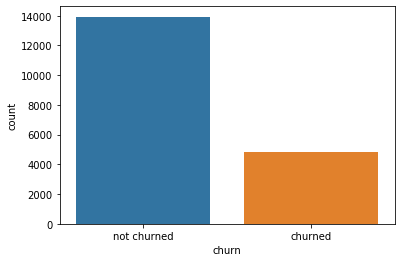

In [36]:
sns.countplot(customer_transactions['churn']);

C:\Users\littu\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


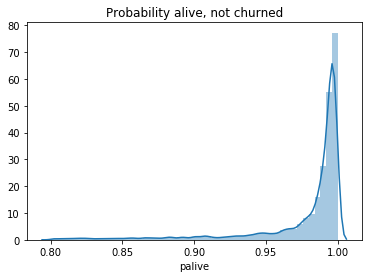

In [37]:
sns.distplot(customer_transactions[customer_transactions['churn']=='not churned']['palive']).set_title('Probability alive, not churned');

In [39]:
customer_transactions['churn'].value_counts()

not churned    13936
churned         4830
Name: churn, dtype: int64

In [48]:
customer_transactions.head()

,frequency,recency,T,monetary_value,palive,churn
user_id,,,,,,
user_0,121.0,471.0,485.0,112.742231,0.986337,not churned
user_1,48.0,391.0,470.0,125.914167,0.119395,churned
user_10,296.0,492.0,497.0,175.989595,0.996782,not churned
user_100,72.0,477.0,486.0,287.886389,0.997392,not churned
user_1000,15.0,171.0,495.0,1420.922667,0.000021,churned


In [62]:
r_labels = range(5, 0, -1); f_labels = range(1, 6)# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(customer_transactions['recency'], q=5, labels=r_labels)# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(customer_transactions['frequency'], q=5, labels=f_labels)# Create new columns R and F 
customer_transactions = customer_transactions.assign(R = r_groups.values, F = f_groups.values)
customer_transactions.head()

,frequency,recency,T,monetary_value,palive,churn,R,F
user_id,,,,,,,,
user_0,121.0,471.0,485.0,112.742231,0.986337,not churned,1,5
user_1,48.0,391.0,470.0,125.914167,0.119395,churned,1,4
user_10,296.0,492.0,497.0,175.989595,0.996782,not churned,1,5
user_100,72.0,477.0,486.0,287.886389,0.997392,not churned,1,4
user_1000,15.0,171.0,495.0,1420.922667,0.000021,churned,4,2


In [66]:
# Create labels for MonetaryValue
m_labels = range(1, 6)# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(customer_transactions['monetary_value'], q=5, labels=m_labels)# Create new column M
customer_transactions = customer_transactions.assign(M = m_groups.values)

In [67]:
customer_transactions.head()


,frequency,recency,T,monetary_value,palive,churn,R,F,M
user_id,,,,,,,,,
user_0,121.0,471.0,485.0,112.742231,0.986337,not churned,1,5,4
user_1,48.0,391.0,470.0,125.914167,0.119395,churned,1,4,4
user_10,296.0,492.0,497.0,175.989595,0.996782,not churned,1,5,4
user_100,72.0,477.0,486.0,287.886389,0.997392,not churned,1,4,5
user_1000,15.0,171.0,495.0,1420.922667,0.000021,churned,4,2,5


In [68]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): 
    return str(x['R']) + str(x['F']) + str(x['M'])
customer_transactions['RFM_Segment_Concat'] = customer_transactions.apply(join_rfm, axis=1)


In [70]:
customer_transactions['RFM_Score']=customer_transactions[['R','F','M']].sum(axis=1)

In [78]:
customer_transactions.head(20)

,frequency,recency,T,monetary_value,palive,churn,R,F,M,RFM_Segment_Concat,RFM_Score
user_id,,,,,,,,,,,
user_0,121.0,471.0,485.0,112.742231,9.863371e-01,not churned,1,5,4,154,10.0
user_1,48.0,391.0,470.0,125.914167,1.193953e-01,churned,1,4,4,144,9.0
user_10,296.0,492.0,497.0,175.989595,9.967816e-01,not churned,1,5,4,154,10.0
user_100,72.0,477.0,486.0,287.886389,9.973915e-01,not churned,1,4,5,145,10.0
user_1000,15.0,171.0,495.0,1420.922667,2.126854e-05,churned,4,2,5,425,11.0
user_10000,51.0,270.0,276.0,360.173333,9.970593e-01,not churned,2,4,5,245,11.0
user_10001,16.0,175.0,277.0,187.326875,1.454457e-01,churned,3,2,4,324,9.0
user_10002,39.0,247.0,285.0,535.155897,7.452881e-01,churned,3,4,5,345,12.0
user_10004,54.0,247.0,258.0,34.878889,9.905851e-01,not churned,3,4,2,342,9.0


# test/experiment to check whether we are actually reducing churn?

whether we are reducing churn or not can be viewed by calculation ration between the total number of customers lost and the total number of customers (is called churn rate). If churn customers are decreasing, then the churn rate will be decreasing. This indicates the business action plans and campaigns are effective and improving the business.

In [92]:
campaign=notifications[notifications['reason']=='REENGAGEMENT_ACTIVE_FUNDS']

In [114]:
campaign.head()

,reason,channel,status,user_id,created_date
0,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-02 17:58:33.320645
1,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6598,2018-12-01 23:09:37.367127
2,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_4151,2018-12-04 02:57:56.425660
3,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_1408,2018-12-11 02:04:46.284683
4,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6292,2018-12-14 17:09:58.900808


In [111]:
transactions['created_date'].dtype

dtype('<M8[ns]')

In [140]:
def before_campaign_count(userid):
    notificationdate=notifications[(notifications['user_id']==userid)&(notifications['reason']=='REENGAGEMENT_ACTIVE_FUNDS')]['created_date'].max()
    before_noti_trans=transactions[(transactions['created_date']< notificationdate)&(transactions['user_id']==userid)]['transaction_id']
    before_noti_trans_count=before_noti_trans.count()
    return before_noti_trans_count

In [141]:
def after_campaign_count(userid):
    notificationdate=notifications[(notifications['user_id']==userid)&(notifications['reason']=='REENGAGEMENT_ACTIVE_FUNDS')]['created_date'].max()
    after_noti_trans=transactions[(transactions['created_date']> notificationdate)&(transactions['user_id']==userid)]['transaction_id']
    after_noti_trans_count=after_noti_trans.count()
    return after_noti_trans_count

In [121]:
notifications[(notifications['user_id']=='user_1408')&(notifications['reason']=='REENGAGEMENT_ACTIVE_FUNDS')]['created_date'].max()

Timestamp('2018-12-11 02:04:46.284683')

In [156]:
before_campaign_count('user_10002')

84

In [157]:
after_campaign_count('user_10002')

5

In [136]:
customer_transactions.reset_index(level=0,inplace=True)

In [138]:
customer_transactions.dtypes

user_id                 object
frequency              float64
recency                float64
T                      float64
monetary_value         float64
palive                 float64
churn                   object
R                     category
F                     category
M                     category
RFM_Segment_Concat      object
RFM_Score              float64
dtype: object

In [154]:
customer_transactions.head()

,user_id,frequency,recency,T,monetary_value,palive,churn,R,F,M,RFM_Segment_Concat,RFM_Score
0,user_0,121.0,471.0,485.0,112.742231,0.986337,not churned,1,5,4,154,10.0
1,user_1,48.0,391.0,470.0,125.914167,0.119395,churned,1,4,4,144,9.0
2,user_10,296.0,492.0,497.0,175.989595,0.996782,not churned,1,5,4,154,10.0
3,user_100,72.0,477.0,486.0,287.886389,0.997392,not churned,1,4,5,145,10.0
4,user_1000,15.0,171.0,495.0,1420.922667,0.000021,churned,4,2,5,425,11.0


In [211]:
import pandasql as pds

noti_trans=pds.sqldf("select camp.user_id as user_id, count(*) as count_after_campaign from(select tran.user_id as user_id, tran.created_date as created_date, noti.notification_date as notification_date from (select user_id,created_date from transactions )as tran left join ( select user_id, max(created_date) as notification_date from notifications where reason = 'REENGAGEMENT_ACTIVE_FUNDS' group by user_id ) as noti on tran.user_id=noti.user_id ) as camp where camp.created_date > camp.notification_date group by camp.user_id order by camp.user_id")

In [218]:
noti_trans.dtypes

user_id    object
dtype: object

In [198]:
max_notifications=notifications[notifications['reason']=='REENGAGEMENT_ACTIVE_FUNDS'].groupby('user_id').agg({'created_date': lambda x: x.max()})

In [199]:
max_notifications1.loc['user_0','created_date']

Timestamp('2019-02-13 00:00:36.630466')

In [206]:
def nots(userid):
    return max_notifications1.loc[userid,'created_date']

In [209]:
before_campaign_count('user_10')

0

In [202]:
def before_campaign_count_improved(userid):
    notificationdate=max_notifications1.loc[userid,'created_date']
    before_noti_trans=transactions[(transactions['created_date']< notificationdate)&(transactions['user_id']==userid)]['transaction_id']
    before_noti_trans_count=before_noti_trans.count()
    return before_noti_trans_count

In [204]:
before_campaign_count_improved('user_1')

105

before_camp=customer_transactions['user_id'].apply(before_campaign_count_improved)

In [147]:
campaign_effect=pd.DataFrame({'user_id':[],'before_campaign_count':[],'after_campaign_count':[]})

customer_transactions['user_id'].apply(before_campaign_count)


for userid in  customer_transactions['user_id']:
    print(userid)
    notificationdate=notifications[(notifications['user_id']==userid)&(notifications['reason']=='REENGAGEMENT_ACTIVE_FUNDS')]['created_date'].max()
    after_noti_trans=transactions[(transactions['created_date']>= notificationdate)&(transactions['user_id']==userid)]['transaction_id']
    after_noti_trans_count=after_noti_trans.count()
    print(after_noti_trans_count)
    before_noti_trans=transactions[(transactions['created_date']< notificationdate)&(transactions['user_id']==userid)]['transaction_id']
    before_noti_trans_count=before_noti_trans.count()
    print(before_noti_trans_count)
    campaign_effect.append(userid,before_noti_trans_count,after_noti_trans_count)